### Importing Libraries

In [344]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [346]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter, OrderedDict
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# matplotlib defaults
# plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
# plt.rc(
#     "axes",
#     labelweight="bold",
#     labelsize="large",
#     titleweight="bold",
#     titlesize=14,
#     titlepad=10,
# )

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(1)

# 1. Data exploration and pre-processing

In [6]:
# load json
df = pd.read_json('../datas/News_Category_Dataset_v3.json', lines=True)
df.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

In [7]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [8]:
df.describe()

date
count                         209527
mean   2015-04-30 00:44:14.344308736
min              2012-01-28 00:00:00
25%              2013-08-10 00:00:00
50%              2015-03-16 00:00:00
75%              2016-11-01 00:00:00
max              2022-09-23 00:00:00

In [9]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#222222',
                                    'color': '#F0F0F0',
                                    'border': '1.5px  solid black'})

In [10]:
df

link  \
0       https://www.huffpost.com/entry/covid-boosters-...   
1       https://www.huffpost.com/entry/american-airlin...   
2       https://www.huffpost.com/entry/funniest-tweets...   
3       https://www.huffpost.com/entry/funniest-parent...   
4       https://www.huffpost.com/entry/amy-cooper-lose...   
...                                                   ...   
209522  https://www.huffingtonpost.com/entry/rim-ceo-t...   
209523  https://www.huffingtonpost.com/entry/maria-sha...   
209524  https://www.huffingtonpost.com/entry/super-bow...   
209525  https://www.huffingtonpost.com/entry/aldon-smi...   
209526  https://www.huffingtonpost.com/entry/dwight-ho...   

                                                 headline   category  \
0       Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1       American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2       23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3       The Funniest Tweets From Parents This Week (Se...  PARENTING   
4       Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   
...                                                   ...        ...   
209522  RIM CEO Thorsten Heins' 'Significant' Plans Fo...       TECH   
209523  Maria Sharapova Stunned By Victoria Azarenka I...     SPORTS   
209524  Giants Over Patriots, Jets Over Colts Among  M...     SPORTS   
209525  Aldon Smith Arrested: 49ers Linebacker Busted ...     SPORTS   
209526  Dwight Howard Rips Teammates After Magic Loss ...     SPORTS   

                                        short_description  \
0       Health experts said it is too early to predict...   
1       He was subdued by passengers and crew when he ...   
2       "Until you have a dog you don't understand wha...   
3       "Accidentally put grown-up toothpaste on my to...   
4       Amy Cooper accused investment firm Franklin Te...   
...                                                   ...   
209522  Verizon Wireless and AT&T are already promotin...   
209523  Afterward, Azarenka, more effusive with the pr...   
209524  Leading up to Super Bowl XLVI, the most talked...   
209525  CORRECTION: An earlier version of this story i...   
209526  The five-time all-star center tore into his te...   

                     authors       date  
0       Carla K. Johnson, AP 2022-09-23  
1             Mary Papenfuss 2022-09-23  
2              Elyse Wanshel 2022-09-23  
3           Caroline Bologna 2022-09-23  
4             Nina Golgowski 2022-09-22  
...                      ...        ...  
209522      Reuters, Reuters 2012-01-28  
209523                       2012-01-28  
209524                       2012-01-28  
209525                       2012-01-28  
209526                       2012-01-28  

[209527 rows x 6 columns]

In [322]:
df[df['headline'] == '']

link headline  \
90944   https://www.huffingtonpost.com/entry/lincoln-2...            
95567   https://www.huffingtonpost.com/entry/post_9671...            
103675  https://www.huffingtonpost.com/entry/us-and-eu...            
109100  https://www.huffingtonpost.com/entry/disney-ce...            
110153  https://www.huffingtonpost.com/entry/beverly-h...            
122145  https://www.huffingtonpost.com/entry/beverly-h...            

            category                                  short_description  \
90944       POLITICS                                                      
95567       RELIGION  Let everyone not wrapped in tired and disprove...   
103675     WORLDPOST                                                      
109100      BUSINESS                                                      
110153         MEDIA                                                      
122145  QUEER VOICES                                                      

                                                  authors       date  
90944   Robert Moran, ContributorRobert Moran leads Br... 2015-08-22  
95567   Matthew Fox, ContributorRadical theologian Mat... 2015-06-30  
103675  Natasha Srdoc, ContributorAuthor, Economist, C... 2015-03-29  
109100  Gary Snyder, ContributorWriter and Media Strat... 2015-01-25  
110153  Gary Snyder, ContributorWriter and Media Strat... 2015-01-13  
122145  Gary Snyder, ContributorWriter and Media Strat... 2014-08-28

In [321]:
df[df['short_description'] == '']

link  \
20773   https://www.huffingtonpost.com/entry/the-big-b...   
21523   https://www.huffingtonpost.com/entry/inside-ru...   
22793   https://www.huffingtonpost.com/entry/syrian-re...   
32223   https://www.huffingtonpost.com/entry/your-guid...   
34488   https://www.huffingtonpost.com/entry/the-bechd...   
...                                                   ...   
206924  https://www.huffingtonpost.com/entry/true-lgbt...   
206939  https://www.huffingtonpost.com/entry/chasing-i...   
208803  https://www.huffingtonpost.com/entry/love-is-l...   
208865  https://www.huffingtonpost.com/entry/zach-hust...   
208940  https://www.huffingtonpost.com/entry/nail-tren...   

                                                 headline        category  \
20773                                   The Big Blue Wave          COMEDY   
21523   Inside Rukban Camp, One Of Syria’s Most Desper...      WORLD NEWS   
22793   Syrian Refugees Return From Lebanon Only To Fl...      WORLD NEWS   
32223   Your Guide To The Best BBQ In St. Louis Accord...           TASTE   
34488                                    The Bechdel Test          COMEDY   
...                                                   ...             ...   
206924  True LGBTQ Stories: When A College Football Te...    QUEER VOICES   
206939  'Chasing Ice' -- The Climate Change Debate Is ...     ENVIRONMENT   
208803  Practice for International Kissing Day: 'Love ...          IMPACT   
208865  Zach Huston, Victim of Brutal Ohio School Bull...    QUEER VOICES   
208940    5 Nail Trends That You Can Actually Do Yourself  STYLE & BEAUTY   

       short_description                                            authors  \
20773                     Shan Wells, ContributorSciency sun venerator +...   
21523                                           Yasser Allawi, Syria Deeply   
22793                                          Abby Sewell, Refugees Deeply   
32223                                                                         
34488                     Hilary Fitzgerald Campbell, ContributorHilary'...   
...                  ...                                                ...   
206924                    Nathan Manske, Contributor\nExecutive Director...   
206939                    Greg Reitman, Contributor\nFounder of Blue Wat...   
208803                    Karen Dalton-Beninato, Contributor\nWriter Nea...   
208865                    Ian Thompson, Contributor\nLegislative Represe...   
208940                            Brooke Moreland, Contributor\nContributor   

             date  
20773  2017-11-10  
21523  2017-10-31  
22793  2017-10-14  
32223  2017-06-19  
34488  2017-05-24  
...           ...  
206924 2012-02-25  
206939 2012-02-25  
208803 2012-02-05  
208865 2012-02-04  
208940 2012-02-03  

[19712 rows x 6 columns]

## 1.2 Text data visualization

In [11]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  
0  Health experts said it is too early to predict...  
1  He was subdued by passengers and crew when he ...  
2  "Until you have a dog you don't understand wha...  
3  "Accidentally put grown-up toothpaste on my to...  
4  Amy Cooper accused investment firm Franklin Te...

### 1.2.1 TOP 10 Categories of News Articles

In [291]:
cat_df

news_classes  numcat
0         POLITICS   35602
1         WELLNESS   17945
2    ENTERTAINMENT   17362
3           TRAVEL    9900
4   STYLE & BEAUTY    9814
5        PARENTING    8791
6   HEALTHY LIVING    6694
7     QUEER VOICES    6347
8     FOOD & DRINK    6340
9         BUSINESS    5992
10          COMEDY    5400
11          SPORTS    5077
12    BLACK VOICES    4583
13   HOME & LIVING    4320
14         PARENTS    3955
15   THE WORLDPOST    3664
16        WEDDINGS    3653
17           WOMEN    3572
18           CRIME    3562
19          IMPACT    3484
20         DIVORCE    3426
21      WORLD NEWS    3299
22           MEDIA    2944
23      WEIRD NEWS    2777
24           GREEN    2622
25       WORLDPOST    2579
26        RELIGION    2577
27           STYLE    2254
28         SCIENCE    2206
29            TECH    2104
30           TASTE    2096
31           MONEY    1756
32            ARTS    1509
33     ENVIRONMENT    1444
34           FIFTY    1401
35       GOOD NEWS    1398
36       U.S. NEWS    1377
37  ARTS & CULTURE    1339
38         COLLEGE    1144
39   LATINO VOICES    1130
40  CULTURE & ARTS    1074
41       EDUCATION    1014

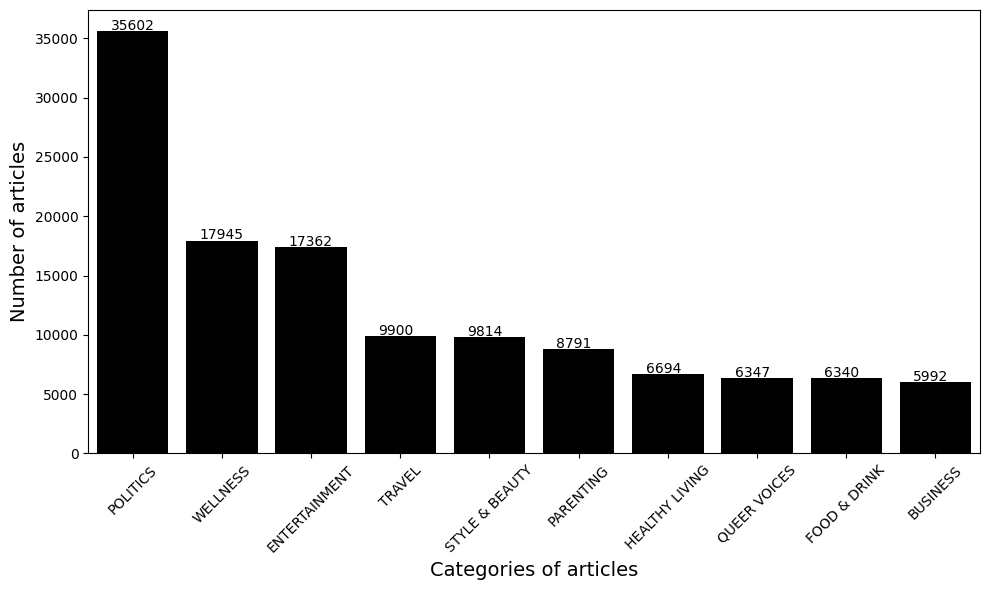

In [347]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'category':'news_classes','count':'numcat'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(cat_df.iloc[: 10, :], x='news_classes', y='numcat', color='#000000')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.15, p.get_height() + 100))
# plt.title("TOP 10 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

### 1.2.2 Lengths of 'headline' and 'short_description' of each categor

In [295]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df = final_df[final_df['len_news'] > 0]  # drop rows with empty news
final_df.head()

category                                     length_of_news  len_news
0  U.S. NEWS  Over 4 Million Americans Roll Up Sleeves For O...       230
1  U.S. NEWS  American Airlines Flyer Charged, Banned For Li...       248
2     COMEDY  23 Of The Funniest Tweets About Cats And Dogs ...       133
3  PARENTING  The Funniest Tweets From Parents This Week (Se...       215
4  U.S. NEWS  Woman Who Called Cops On Black Bird-Watcher Lo...       233

In [296]:
final_df.describe()

len_news
count  209522.000000
mean      172.628144
std        78.549381
min         3.000000
25%       122.000000
50%       170.000000
75%       207.000000
max      1486.000000

In [14]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

category  len_news
24        POLITICS      1486
41       WORLDPOST      1424
4          COLLEGE      1225
16  HEALTHY LIVING      1073
38        WELLNESS      1036

In [15]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

category  len_news
35      U.S. NEWS        73
8         DIVORCE        66
33  THE WORLDPOST        56
36       WEDDINGS        54
21          MONEY        51

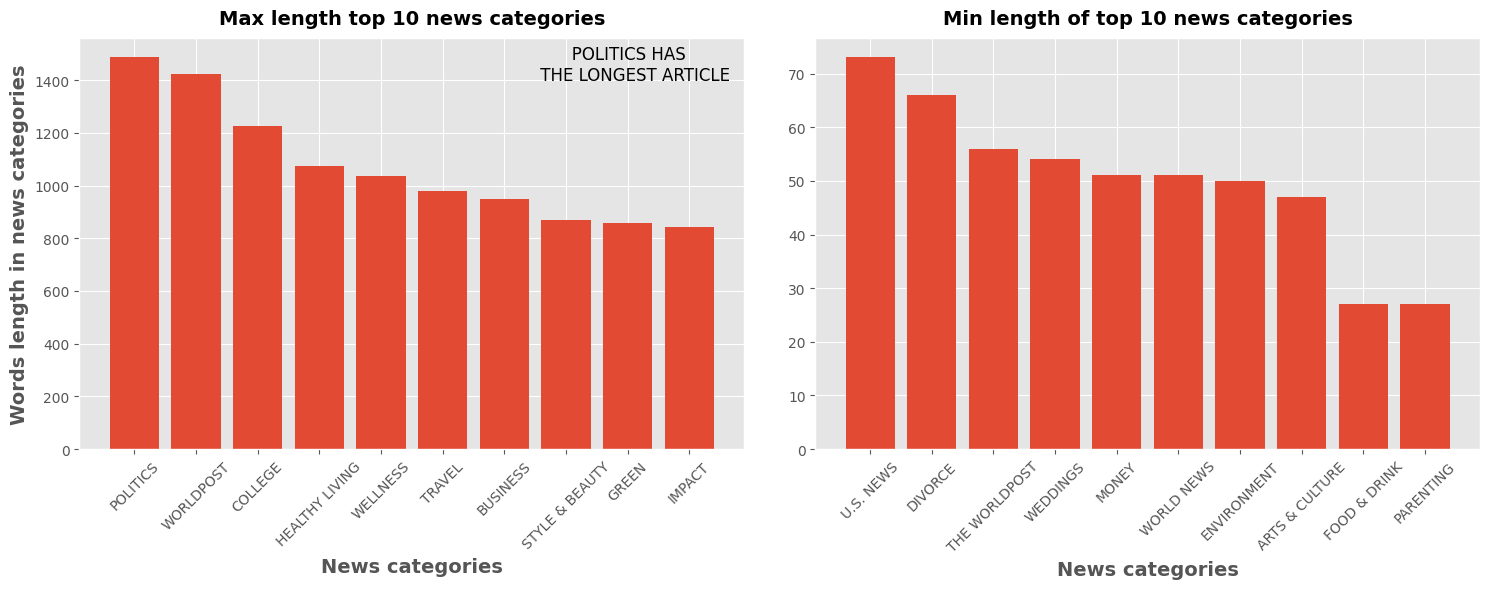

In [16]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

**Key findings:**

1. From all the categories of news **POLITICS** has the **most number of articles** as well as **length of characters** in the article (headlines and short-description)
2. After 'POLITICS' category, 'WORLDPOST', 'COLLEGE', 'HEALTHY LIVING','WELLNESS' categories are in top 5 most length of articles
3. 'POLITICS', 'WELLNESS' and 'ENTERTAINTMENT' are top 3 categories having most number of articles in out dataset.

(-0.5, 1599.5, 599.5, -0.5)

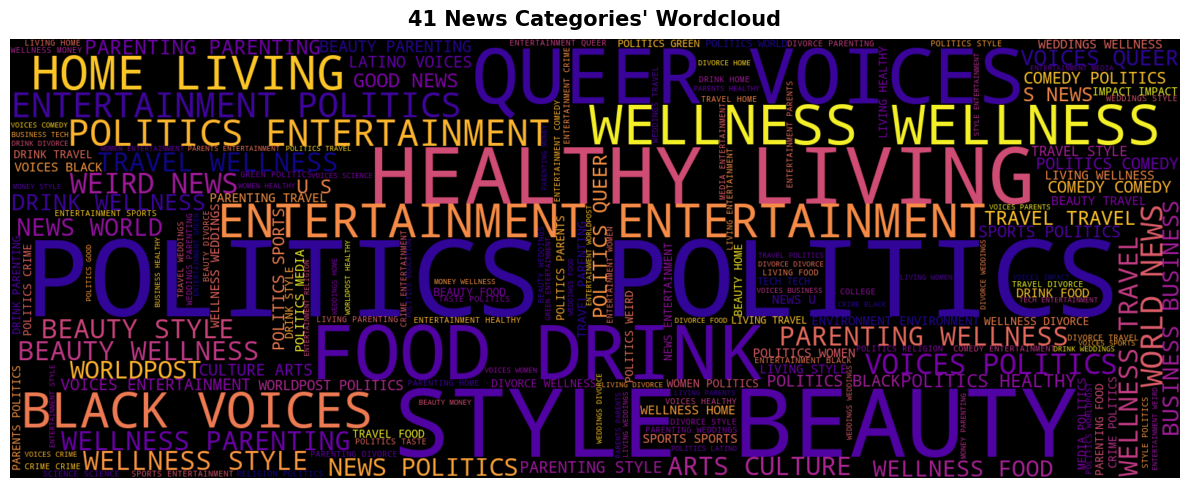

In [17]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

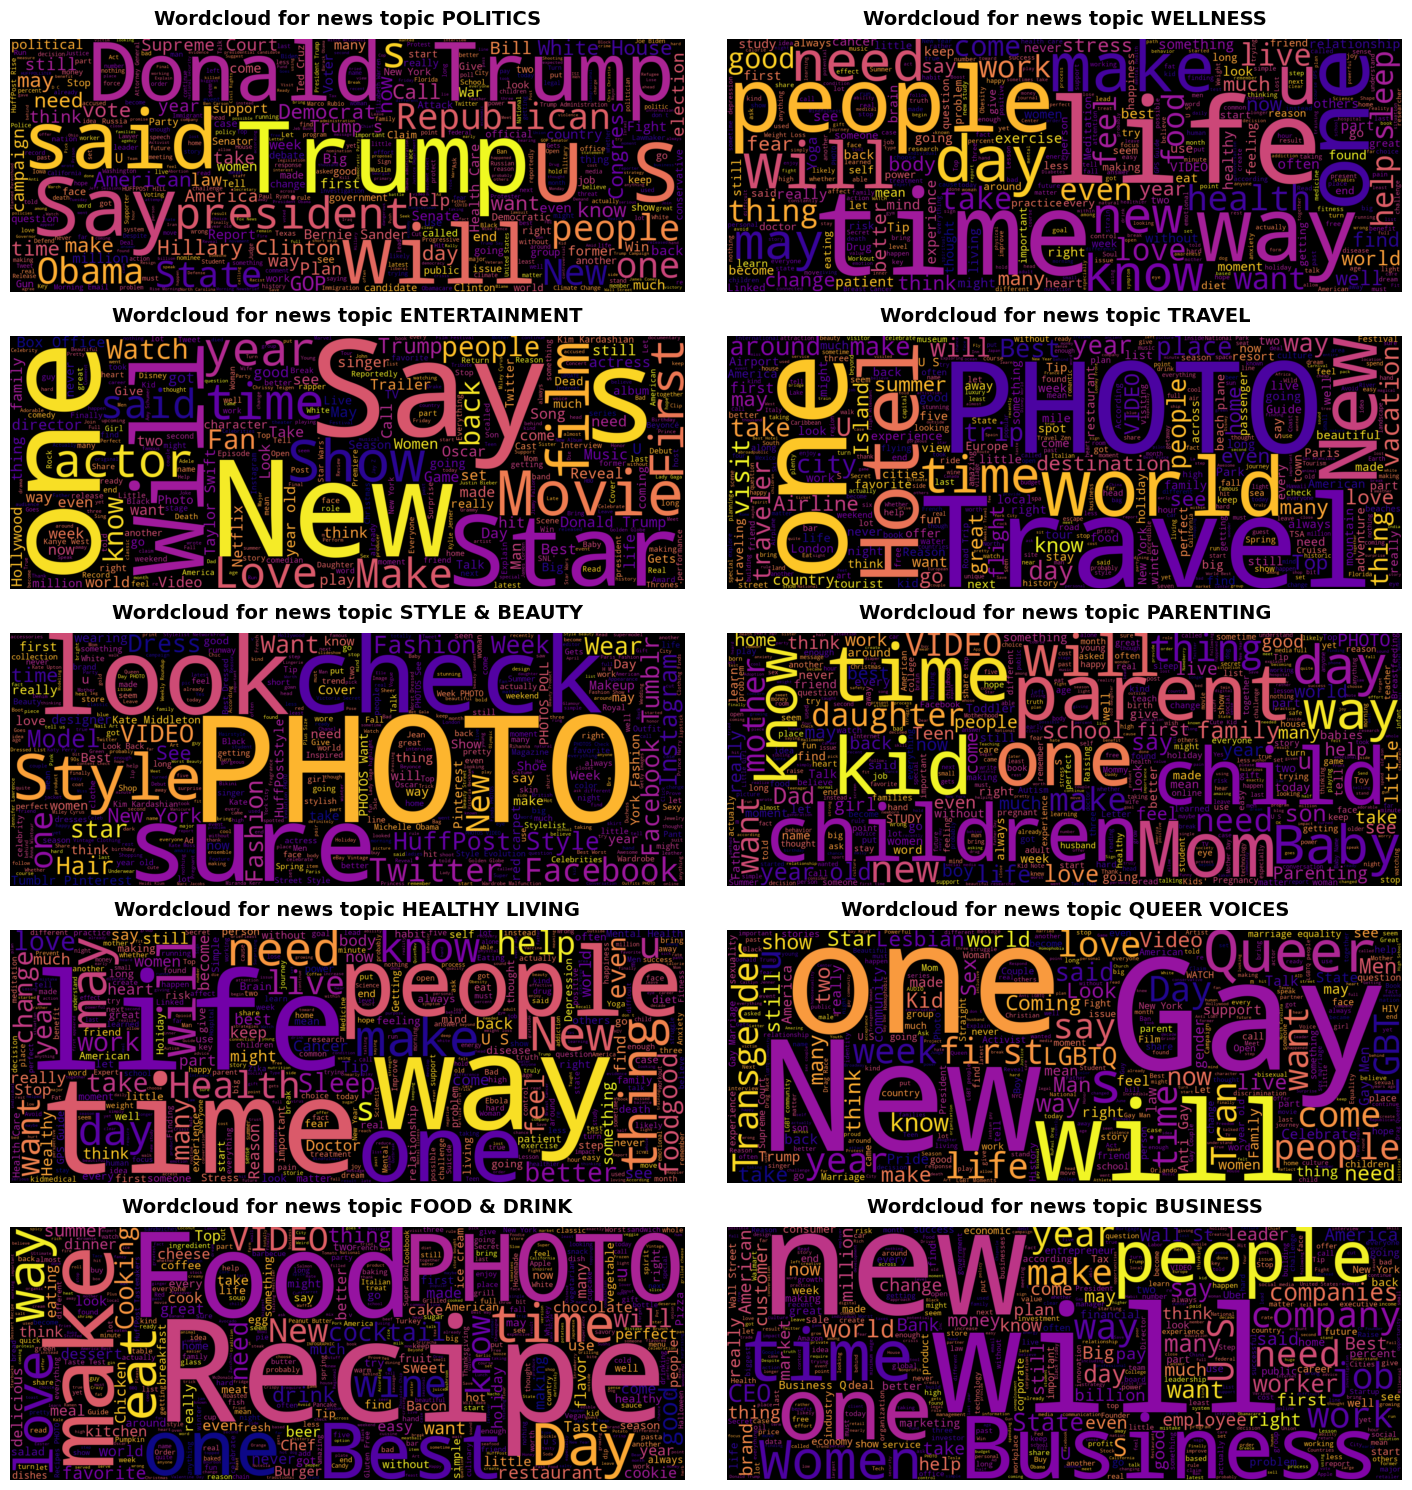

In [18]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

## 1.3 Text-data Preprocessing 

In [19]:
# start with removing some data from politics dataframe ndf
politics_list = list(ndf[ndf['category'] == 'POLITICS'].index) 
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
ndf2 = ndf.copy()
ndf2.drop(list_16, axis=0, inplace=True)

In [20]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+") 
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)

In [21]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",ndf2['length_of_news'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf2['length_of_news'][0]))

Text sentence before pre-processing:
 Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID BoostersHealth experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 million americans roll sleeves omicrontargeted covid boostershealth experts say early predict whether demand match million dose new boosters us order fall


In [22]:
# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

In [23]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 36169394
New chracters length of text data: 23045855


In [24]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5942993
New word length of text data: 3290751


# 2. Tokenization and Vocabulary

In [134]:
# split data set to training set and validation set
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
# y_train = torch.LongTensor(y_train).view(-1,1)
# y_test = torch.LongTensor(y_test).view(-1,1)

shape of input data:  (193527,)
shape of target variable:  (193527,)


In [162]:
# tokenize all the news articles
tokenizer = get_tokenizer("basic_english")
train_tokens = X_train.apply(tokenizer)

# get corpus
corpus = []

for sent in train_tokens:
    corpus.extend(sent)

# get frequency of each word in corpus, store in ordered dictionary
VOCAB_SIZE = 20000
counter = Counter(corpus)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples[:VOCAB_SIZE])

# create vocabulary of words
unk_token = '<unk>'
v = vocab(ordered_dict, specials=[unk_token])
v.set_default_index(v[unk_token])

In [169]:
test_tokens = X_test.apply(tokenizer)

# convert tokens to indices
def token_to_index(tokens):
    return [v[token] for token in tokens]

train_indices = train_tokens.apply(token_to_index).apply(torch.LongTensor)
test_indices = test_tokens.apply(token_to_index).apply(torch.LongTensor)
# train_indices.reset_index(drop=True, inplace=True)
# test_indices.reset_index(drop=True, inplace=True)

# truncation first (since pytorch does not provide max_length argument in pad_sequence)
MAX_LEN = 50
def truncation(x):
    return x[:MAX_LEN]
train_indices = train_indices.apply(truncation)
test_indices = test_indices.apply(truncation)

# padding
train_indices = pad_sequence(train_indices, batch_first=True, padding_value=0)
test_indices = pad_sequence(test_indices, batch_first=True, padding_value=0)

In [170]:
# custom dataset 
class NLPDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [171]:
training_data = NLPDataset(train_indices, y_train)
testing_data = NLPDataset(test_indices, y_test)

BATCH_SIZE = 128
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

# 3. Models

In [259]:
class LSTMClf(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size):
        # label_size should be equal to number of classes
        super(LSTMClf, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hitten2label = nn.Linear(hidden_dim, label_size)
        
    def forward(self, sentences):
        batch_size = sentences.shape[0]
        embeds = self.word_embeddings(sentences)  # from word's idx to embedding
        _, (hidden, _) = self.lstm(embeds)  # input: batch, time step, embedding_dim; output: 1, batch, hidden_dim
        label_probas = self.hitten2label(hidden.view(batch_size, -1))  # input: batch, hidden_dim; output: batch, label_size
        label_scores = F.log_softmax(label_probas, dim=1)
        return label_scores
    
class GRUClf(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size):
        # label_size should be equal to number of classes
        super(GRUClf, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.hitten2label = nn.Linear(hidden_dim, label_size)
        
    def forward(self, sentences):
        batch_size = sentences.shape[0]
        embeds = self.word_embeddings(sentences)  # from word's idx to embedding
        _, hidden = self.rnn(embeds)  # input: batch, time step, embedding_dim; output: 1, batch, hidden_dim
        label_probas = self.hitten2label(hidden.view(batch_size, -1))  # input: batch, hidden_dim; output: batch, label_size
        label_scores = F.log_softmax(label_probas, dim=1)
        return label_scores

# 4. Training the model

In [263]:
# lstm
EMBEDDING_DIM = int(np.floor(np.log2(len(v))))
HIDDEN_DIM = 128

model = LSTMClf(EMBEDDING_DIM, HIDDEN_DIM, len(v), len(cat_df))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

lstm_train_losses = []
lstm_test_losses = []
lstm_train_accs = []
lstm_test_accs = []
for epoch in range(20):
    train_loss_sum = 0
    test_loss_sum = 0
    
    train_acc_sum = 0
    test_acc_sum = 0
    
    train_n = len(train_dataloader.dataset)
    test_n = len(test_dataloader.dataset)
    
    # training
    for batch, (sentences, labels) in enumerate(train_dataloader):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Run our forward pass.
        label_scores = model(sentences)
        
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(label_scores, labels)
        loss.backward()
        optimizer.step()
        
        if (batch + 1) % 100 == 0:
            print(f"Epoch: {epoch + 1} | Batch: {batch + 1} | Loss: {loss.item()}")
        
        # load loss of each batch
        batch_size = sentences.shape[0]
        train_loss_sum += batch_size * loss.item()
        
        # accuracy
        predicted = torch.max(label_scores.data, 1).indices
        train_acc_sum += (predicted == labels).sum().item()
        
        
    # testing
    with torch.no_grad():
        for batch, (sentences, labels) in enumerate(test_dataloader):
            label_scores = model(sentences)
            loss = loss_function(label_scores, labels)
            
            # loss
            batch_size = sentences.shape[0]
            test_loss_sum += batch_size * loss.item()
            
            # accuracy
            predicted = torch.max(label_scores.data, 1).indices
            test_acc_sum += (predicted == labels).sum().item()
            
    # loss
    train_loss_avg = train_loss_sum / train_n
    test_loss_avg = test_loss_sum / test_n
    lstm_train_losses.append(train_loss_avg)
    lstm_test_losses.append(test_loss_avg)
    
    # accuracy
    train_acc_avg = train_acc_sum / train_n
    test_acc_avg = test_acc_sum / test_n
    lstm_train_accs.append(train_acc_avg)
    lstm_test_accs.append(test_acc_avg)

Epoch: 1 | Batch: 100 | Loss: 3.347752094268799
Epoch: 1 | Batch: 200 | Loss: 3.3818154335021973
Epoch: 1 | Batch: 300 | Loss: 3.4879631996154785
Epoch: 1 | Batch: 400 | Loss: 3.367912769317627
Epoch: 1 | Batch: 500 | Loss: 3.319870710372925
Epoch: 1 | Batch: 600 | Loss: 3.4453372955322266
Epoch: 1 | Batch: 700 | Loss: 3.2524826526641846
Epoch: 1 | Batch: 800 | Loss: 3.4508376121520996
Epoch: 1 | Batch: 900 | Loss: 3.3958969116210938
Epoch: 1 | Batch: 1000 | Loss: 3.4426214694976807
Epoch: 1 | Batch: 1100 | Loss: 3.459022045135498
Epoch: 1 | Batch: 1200 | Loss: 3.356806993484497
Epoch: 2 | Batch: 100 | Loss: 3.156209707260132
Epoch: 2 | Batch: 200 | Loss: 3.422640085220337
Epoch: 2 | Batch: 300 | Loss: 3.2986888885498047
Epoch: 2 | Batch: 400 | Loss: 3.069103717803955
Epoch: 2 | Batch: 500 | Loss: 3.1476354598999023
Epoch: 2 | Batch: 600 | Loss: 2.9990203380584717
Epoch: 2 | Batch: 700 | Loss: 3.014739990234375
Epoch: 2 | Batch: 800 | Loss: 3.080702066421509
Epoch: 2 | Batch: 900 | Los

In [264]:
# gru
EMBEDDING_DIM = int(np.floor(np.log2(len(v))))
HIDDEN_DIM = 128

model = GRUClf(EMBEDDING_DIM, HIDDEN_DIM, len(v), len(cat_df))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

gru_train_losses = []
gru_test_losses = []
gru_train_accs = []
gru_test_accs = []
for epoch in range(20):
    train_loss_sum = 0
    test_loss_sum = 0
    
    train_acc_sum = 0
    test_acc_sum = 0
    
    train_n = len(train_dataloader.dataset)
    test_n = len(test_dataloader.dataset)
    
    # training
    for batch, (sentences, labels) in enumerate(train_dataloader):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Run our forward pass.
        label_scores = model(sentences)
        
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(label_scores, labels)
        loss.backward()
        optimizer.step()
        
        if (batch + 1) % 100 == 0:
            print(f"Epoch: {epoch + 1} | Batch: {batch + 1} | Loss: {loss.item()}")
        
        # load loss of each batch
        batch_size = sentences.shape[0]
        train_loss_sum += batch_size * loss.item()
        
        # accuracy
        predicted = torch.max(label_scores.data, 1).indices
        train_acc_sum += (predicted == labels).sum().item()
        
        
    # testing
    with torch.no_grad():
        for batch, (sentences, labels) in enumerate(test_dataloader):
            label_scores = model(sentences)
            loss = loss_function(label_scores, labels)
            
            # loss
            batch_size = sentences.shape[0]
            test_loss_sum += batch_size * loss.item()
            
            # accuracy
            predicted = torch.max(label_scores.data, 1).indices
            test_acc_sum += (predicted == labels).sum().item()
            
    # loss
    train_loss_avg = train_loss_sum / train_n
    test_loss_avg = test_loss_sum / test_n
    gru_train_losses.append(train_loss_avg)
    gru_test_losses.append(test_loss_avg)
    
    # accuracy
    train_acc_avg = train_acc_sum / train_n
    test_acc_avg = test_acc_sum / test_n
    gru_train_accs.append(train_acc_avg)
    gru_test_accs.append(test_acc_avg)

Epoch: 1 | Batch: 100 | Loss: 3.4069302082061768
Epoch: 1 | Batch: 200 | Loss: 3.4475014209747314
Epoch: 1 | Batch: 300 | Loss: 3.354966640472412
Epoch: 1 | Batch: 400 | Loss: 3.2583956718444824
Epoch: 1 | Batch: 500 | Loss: 3.2155251502990723
Epoch: 1 | Batch: 600 | Loss: 3.1494386196136475
Epoch: 1 | Batch: 700 | Loss: 3.1412947177886963
Epoch: 1 | Batch: 800 | Loss: 3.2792630195617676
Epoch: 1 | Batch: 900 | Loss: 3.0425708293914795
Epoch: 1 | Batch: 1000 | Loss: 2.7579100131988525
Epoch: 1 | Batch: 1100 | Loss: 2.90023136138916
Epoch: 1 | Batch: 1200 | Loss: 2.7416326999664307
Epoch: 2 | Batch: 100 | Loss: 2.7695472240448
Epoch: 2 | Batch: 200 | Loss: 2.8744583129882812
Epoch: 2 | Batch: 300 | Loss: 2.591813087463379
Epoch: 2 | Batch: 400 | Loss: 2.5368316173553467
Epoch: 2 | Batch: 500 | Loss: 2.4650046825408936
Epoch: 2 | Batch: 600 | Loss: 2.724031448364258
Epoch: 2 | Batch: 700 | Loss: 2.287564992904663
Epoch: 2 | Batch: 800 | Loss: 2.550914764404297
Epoch: 2 | Batch: 900 | Los

# 5. Model Comparison

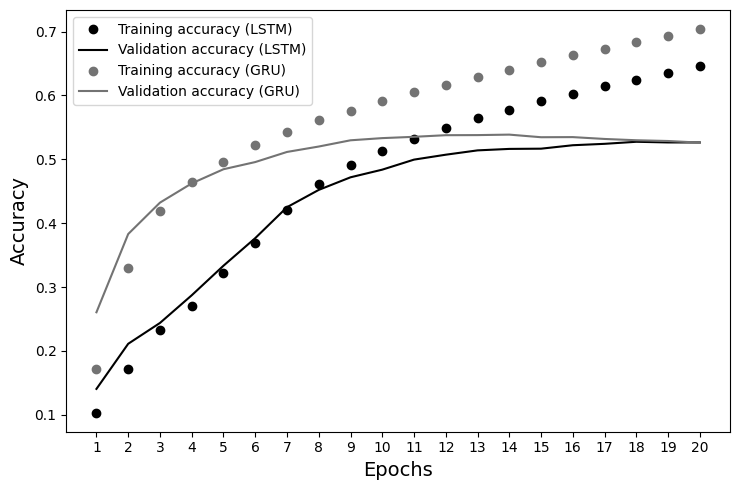

In [350]:
fig, ax = plt.subplots(figsize=(7.5, 5))
epochs = range(1 ,20 + 1)
ax.plot(epochs, lstm_train_accs, 'o', color='#000000', label='Training accuracy (LSTM)')
ax.plot(epochs, lstm_test_accs, color='#000000', label='Validation accuracy (LSTM)')
ax.plot(epochs, gru_train_accs, 'o', color='#737373', label='Training accuracy (GRU)')
ax.plot(epochs, gru_test_accs, color='#737373', label='Validation accuracy (GRU)')
ax.set_xticks(epochs)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
# ax.set_title('Training and validation accuracy')
ax.legend()
plt.show()

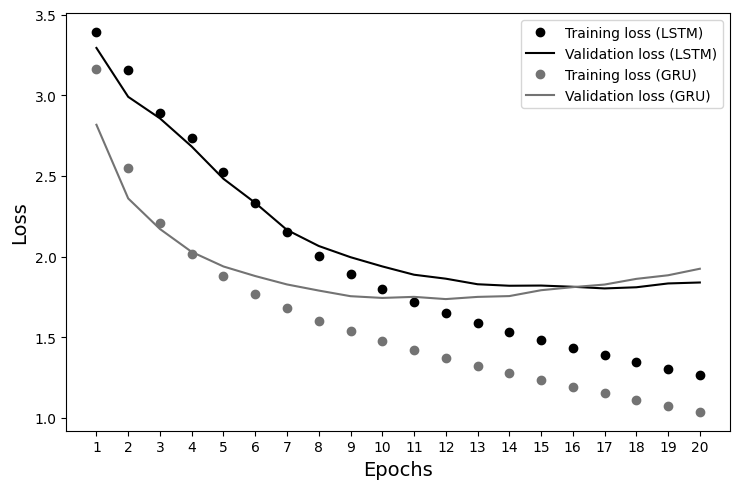

In [351]:
fig, ax = plt.subplots(figsize=(7.5, 5))
epochs = range(1 ,20 + 1)
ax.plot(epochs, lstm_train_losses, 'o', color='#000000', label='Training loss (LSTM)')
ax.plot(epochs, lstm_test_losses, color='#000000', label='Validation loss (LSTM)')
ax.plot(epochs, gru_train_losses, 'o', color='#737373', label='Training loss (GRU)')
ax.plot(epochs, gru_test_losses, color='#737373', label='Validation loss (GRU)')
ax.set_xticks(epochs)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
# ax.set_title('Training and validation loss')
ax.legend()
plt.show()